In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC


from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical





In [2]:
# Képek betöltése és előfeldolgozása
def preprocess_image(img):
    # 1. Szürkeárnyalatossá alakítás
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Sobel éldetektálás
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(sobel_x, sobel_y)

    # 3. Morfológiai gradiens
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    morph_gradient = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, kernel)

    # 4. Felüláteresztő szűrő
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)
    high_pass = cv2.subtract(gray, blurred)

    # 5. Top-hat transzformáció
    top_hat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)

    # 6. Összesített jellemzők (konkatenáció)
    combined_features = np.hstack([
        sobel.flatten(),
        morph_gradient.flatten(),
        high_pass.flatten(),
        top_hat.flatten()
    ])
    
    return combined_features

In [3]:
#elofeldolgozas bemutatasa
def preprocess_image_showcase(img):
    # 1. Szürkeárnyalatossá alakítás
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2. Sobel éldetektálás
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(sobel_x, sobel_y)
    
    # 3. Morfológiai gradiens
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    morph_gradient = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, kernel)

    # 4. Felüláteresztő szűrő
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)
    high_pass = cv2.subtract(gray, blurred)

    # 5. Top-hat transzformáció
    top_hat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)

    # 6. Összesített jellemzők (konkatenáció)
    combined_features = np.hstack([
        sobel,
        morph_gradient,
        high_pass,
        top_hat
    ])
    
    images = []
    
    images.append(gray)
    images.append(sobel)
    images.append(morph_gradient)
    images.append(high_pass)
    images.append(top_hat)
    images.append(blurred)
    

    return images

In [4]:
#korlatlan szamu beolvasas
#img_dir = '/Users/majer/Desktop/Brain_CT/agyikepek_3_osztaly/kepek'
img_dir = '/Users/majer/Documents/GitHub/Sources/agyikepek_3_osztaly/agyikepek_3_osztaly/kepek'
def load_images_from_folder(folder):
    images = []
    labels = []
    cnt = 0
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        
        if img is not None:
            img_resized = cv2.resize(img, (128, 128)) #512x512 erdemes a LeNet-nel
            img_normalized = img_resized / 255.0
            img_flattened = img_normalized.flatten()
            features = preprocess_image(img_resized)
            images.append(img_flattened)
            labels.append(filename)
    return images,labels

#images = []
#images = load_images_from_folder(img_dir)
images, labels = load_images_from_folder(img_dir)


In [ ]:
#korlatolt szamu beolvasas
#img_dir = '/Users/majer/Desktop/Brain_CT/agyikepek_3_osztaly/kepek'
img_dir = '/Users/majer/Documents/GitHub/Sources/agyikepek_3_osztaly/agyikepek_3_osztaly/kepek'
def load_images_from_folder(folder):
    images = []
    labels = []
    cnt = 0
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if cnt < 2000:
            if img is not None:
                img_resized = cv2.resize(img, (128, 128)) #512x512 erdemes a LeNet-nel
                img_normalized = img_resized / 255.0
                img_flattened = img_normalized.flatten()
                features = preprocess_image(img_resized)
                images.append(img_flattened)
                labels.append(filename)
                cnt = cnt+1
    return images,labels

#images = []
#images = load_images_from_folder(img_dir)
images, labels = load_images_from_folder(img_dir)
label = labels[0:2000]


In [5]:
#labels = os.listdir(img_dir)
print(len(images))
print(len(labels))
print(labels)
for i in range(len(labels)):
    tmp = labels[i].split('.')
    labels[i] = tmp[0][-1]

print(labels)


3064
3064
['1000_3.png', '1001_3.png', '1002_3.png', '1003_3.png', '1004_3.png', '1005_3.png', '1006_3.png', '1007_3.png', '1008_3.png', '1009_3.png', '100_1.png', '1010_3.png', '1011_3.png', '1012_3.png', '1013_3.png', '1014_3.png', '1015_3.png', '1016_3.png', '1017_3.png', '1018_3.png', '1019_3.png', '101_1.png', '1020_3.png', '1021_3.png', '1022_3.png', '1023_3.png', '1024_3.png', '1025_3.png', '1026_3.png', '1027_3.png', '1028_3.png', '1029_3.png', '102_1.png', '1030_3.png', '1031_3.png', '1032_3.png', '1033_3.png', '1034_3.png', '1035_3.png', '1036_3.png', '1037_3.png', '1038_3.png', '1039_3.png', '103_1.png', '1040_3.png', '1041_3.png', '1042_3.png', '1043_3.png', '1044_3.png', '1045_3.png', '1046_3.png', '1047_3.png', '1048_3.png', '1049_3.png', '104_1.png', '1050_3.png', '1051_3.png', '1052_3.png', '1053_3.png', '1054_3.png', '1055_3.png', '1056_3.png', '1057_3.png', '1058_3.png', '1059_3.png', '105_1.png', '1060_3.png', '1061_3.png', '1062_3.png', '1063_3.png', '1064_3.png', '

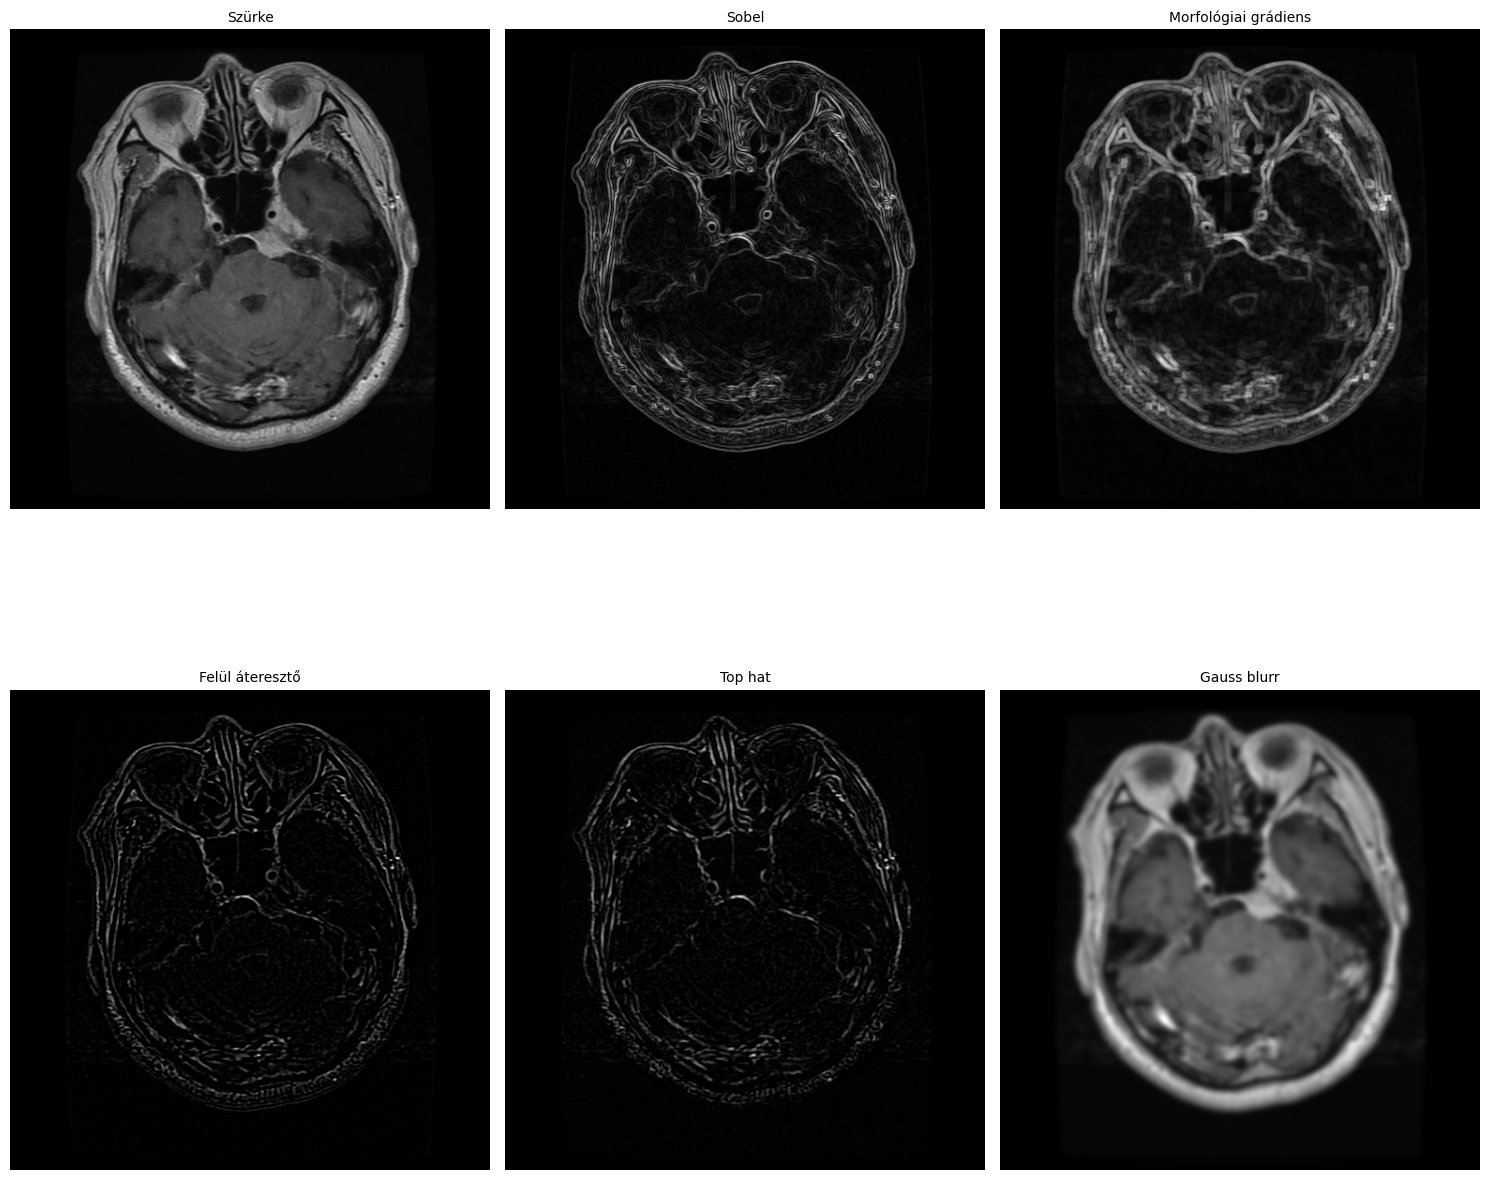

In [6]:
image_sc = cv2.imread('/Users/majer/Documents/GitHub/Sources/agyikepek_3_osztaly/agyikepek_3_osztaly/kepek/6_1.png')
sc = preprocess_image_showcase(image_sc)
cimkek = ['Szürke', 'Sobel', 'Morfológiai grádiens', 'Felül áteresztő', 'Top hat', 'Gauss blurr']

fig, axes = plt.subplots(2, 3, figsize=(15, 15))  # Igazított rács, hogy legyen hely a 7 képnek
for i, ax in enumerate(axes.flat[:len(sc)]):  # Csak a `sc` hosszáig iterál
    ax.imshow(sc[i], cmap='gray')  # Szürkeárnyalatos megjelenítés
    ax.set_title(cimkek[i], fontsize=10)  # Hozzáadja a címkét
    ax.axis('off')  # Kikapcsolja a tengelyeket

# Automatikus igazítás
plt.tight_layout()
plt.show()

In [7]:
df = pd.DataFrame()
df['label']=labels
df['image']=images
print(df.head())
print(df['label'].value_counts())

  label                                              image
0     3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1     3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2     3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3     3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4     3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
label
2    1426
3     930
1     708
Name: count, dtype: int64


In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [ ]:
#random forest gridsearchel
param_grid = {
    'n_estimators': [50, 100, 200],         # Az erdő fáinak száma
    'max_depth': [None, 10, 20, 30],       # A fa maximális mélysége
    'min_samples_split': [2, 5, 10],       # Minimális minta a hasításhoz
    'min_samples_leaf': [1, 2, 4],         # Minimális minta egy levélnél
    'bootstrap': [True, False]             # Bootstrap mintavétel
}

# Random Forest modell inicializálása
rf = RandomForestClassifier(random_state=42)

# GridSearchCV inicializálása
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Optimalizáció futtatása
grid_search.fit(X_train, y_train)

# Legjobb paraméterek és modell
print("Legjobb paraméterek:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Modell kiértékelése
y_pred = best_rf.predict(X_test)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Validációs pontosság: 0.9429037520391517
Validációs veszteség (log loss): 0.23530509358685148


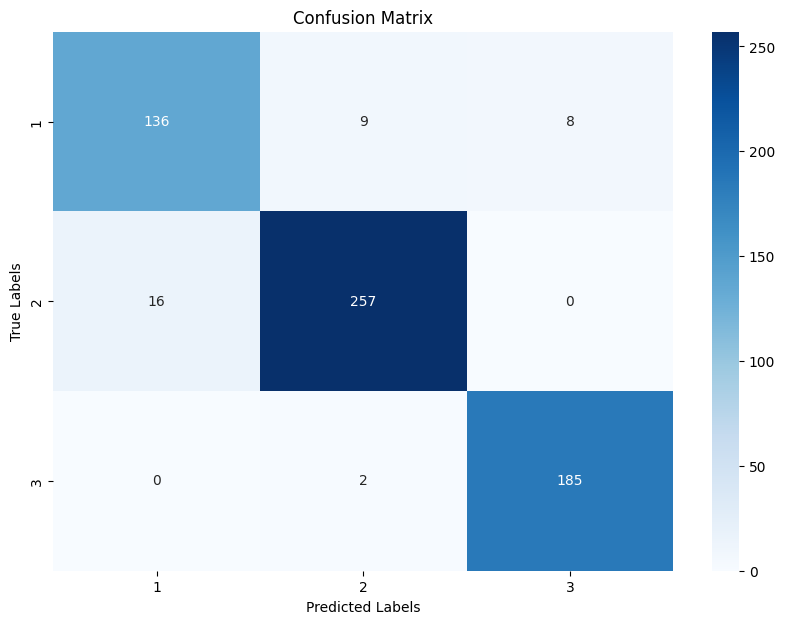

Osztályozási jelentés:
              precision    recall  f1-score   support

           1       0.89      0.89      0.89       153
           2       0.96      0.94      0.95       273
           3       0.96      0.99      0.97       187

    accuracy                           0.94       613
   macro avg       0.94      0.94      0.94       613
weighted avg       0.94      0.94      0.94       613



In [9]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

acc= accuracy_score(y_test,y_pred)

validation_accuracy = accuracy_score(y_test, y_pred)
print("Validációs pontosság:", validation_accuracy)

validation_loss = log_loss(y_test, y_pred_proba)
print("Validációs veszteség (log loss):", validation_loss)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print("Osztályozási jelentés:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Validációs pontosság: 0.8776508972267537
              precision    recall  f1-score   support

           1       0.77      0.75      0.76       153
           2       0.89      0.88      0.88       273
           3       0.95      0.99      0.97       187

    accuracy                           0.88       613
   macro avg       0.87      0.87      0.87       613
weighted avg       0.88      0.88      0.88       613



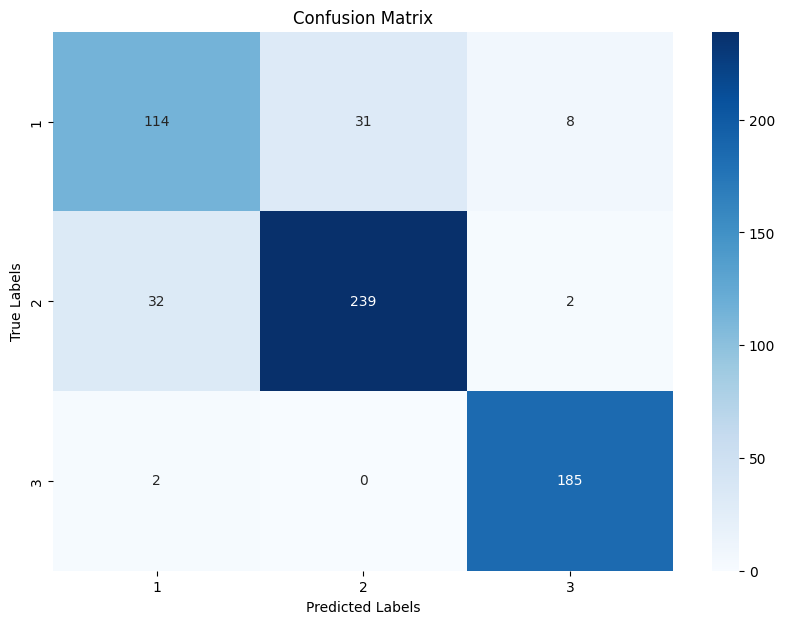

In [12]:
#svm
"""
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_model = GridSearchCV(SVC(probability=True), svm_params, cv=5, scoring='accuracy')
"""

svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
validation_accuracy = accuracy_score(y_test, y_pred)
print("Validációs pontosság:", validation_accuracy)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#print("SVM legjobb paraméterek:", svm_model.best_params_)
#print("SVM validációs pontosság:", svm_model.best_score_)


In [ ]:
#gradient boosting
"""""
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_model = GridSearchCV(GradientBoostingClassifier(), gb_params, cv=5, scoring='accuracy')
gb_model.fit(X_train, y_train)
"""

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

validation_accuracy = accuracy_score(y_test, y_pred)
print("Validációs pontosság:", validation_accuracy)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
#print("Gradient Boosting legjobb paraméterek:", gb_model.best_params_)
#print("Gradient Boosting validációs pontosság:", gb_model.best_score_)

In [45]:
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train_cnn = to_categorical(y_train)  # One-hot kódolás a címkékhez
y_test_cnn = to_categorical(y_test)
#28x28 as beolvasas kell ehez a modellhez

X_train_resized = np.array([cv2.resize(img, (28, 28)) for img in X_train])
X_test_resized = np.array([cv2.resize(img, (28, 28)) for img in X_test])

X_train_cnn = X_train_resized.reshape(-1, 28, 28, 1)
X_test_cnn = X_test_resized.reshape(-1, 28, 28, 1)



lenet5 = Sequential([
    # 1. Konvolúciós réteg
    Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=(28, 28, 1), padding='same'),
    AveragePooling2D(pool_size=(2, 2), strides=2),
    
    # 2. Konvolúciós réteg
    Conv2D(filters=16, kernel_size=(5, 5), activation='tanh'),
    AveragePooling2D(pool_size=(2, 2), strides=2),
    
    # Laposítás
    Flatten(),
    
    # 3. Fully connected réteg
    Dense(120, activation='tanh'),
    
    # 4. Fully connected réteg
    Dense(84, activation='tanh'),
    
    # 5. Kimeneti réteg
    Dense(y_train_cnn.shape[1], activation='softmax')
])

# Modell fordítása
lenet5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\majer\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
#tanitas
history = lenet5.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=30, batch_size=32)

Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.8746e-05 - val_accuracy: 0.7341 - val_loss: 2.1594
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.6823e-05 - val_accuracy: 0.7374 - val_loss: 2.1779
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5874e-05 - val_accuracy: 0.7325 - val_loss: 2.1853
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.3625e-05 - val_accuracy: 0.7406 - val_loss: 2.1936
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.3376e-05 - val_accuracy: 0.7341 - val_loss: 2.1988
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.1476e-05 - val_accuracy: 0.7390 - val_loss: 2.2086
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.1904e-05 - val_accuracy: 0.7325 - val_loss: 2.2254
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9978e-05 - 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7242 - loss: 2.4190
LeNet-5 teszt pontosság: 0.7308319807052612


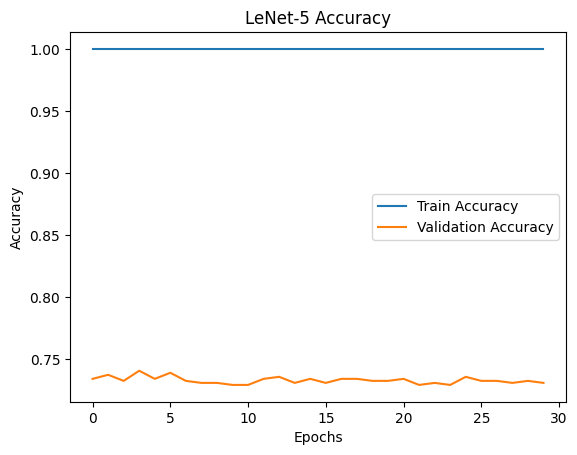

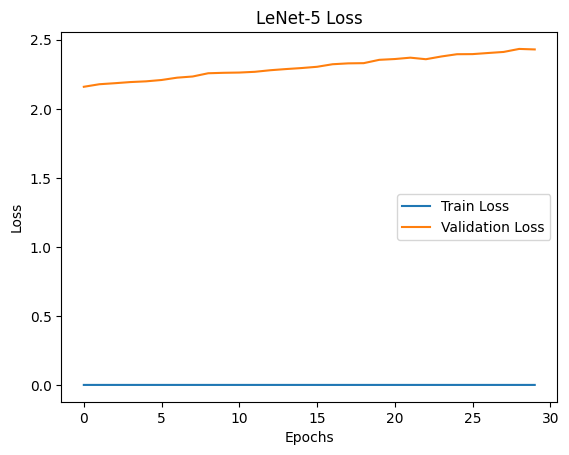

In [51]:
loss, accuracy = lenet5.evaluate(X_test_cnn, y_test_cnn)
print("LeNet-5 teszt pontosság:", accuracy)

# Tanulási görbe megjelenítése
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LeNet-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LeNet-5 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()